In [ ]:
!pip install sentence_transformers
!pip install nltk
!pip install gensim
!pip install transformers

In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import RegexpTokenizer,word_tokenize
from nltk.corpus import stopwords,wordnet
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import csv
import re
from gensim.models import Word2Vec
import gensim
import gensim.downloader as gensim_api
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score,classification_report 
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestClassifier, ExtraTreesClassifier, ExtraTreesClassifier, StackingClassifier, StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

In [4]:
train = pd.read_csv('train_6128.csv')
test = pd.read_csv('test_1532.csv')

# Text preparation for the analysis

In [8]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

wordnet_lemmatizer = WordNetLemmatizer()
#tokenizer = RegexpTokenizer(r'[a-z]+') 
stop_words = set(stopwords.words('english'))
def preprocess(document):
    document = document.lower() # Convert to lowercase
    words = word_tokenize(document) # Tokenize
    words = [w for w in words if not w in stop_words] # Removing stopwords
    # Lemmatizing
    for pos in [wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV]:
        words = [wordnet_lemmatizer.lemmatize(x, pos) for x in words]
    return " ".join(words)



[nltk_data] Downloading package wordnet to /Users/george/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/george/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/george/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
#### new ####
train['MLclass'] = train['MLclass'].astype('str')
test['MLclass'] = test['MLclass'].astype('str')
train['Text'] = train['Text'].astype('str')
test['Text'] = test['Text'].astype('str')

train["prep_text"] = ""
for i in range(0,train.shape[0]):
    train['Text'][i]=re.sub('\r',' ',train['Text'][i])
    train.loc[i,"prep_text"]=preprocess(train.loc[i,'Text'])
test["prep_text"] = ""
for i in range(0,test.shape[0]):
    test['Text'][i]=re.sub('\r',' ',test['Text'][i])
    test.loc[i,"prep_text"]=preprocess(test.loc[i,'Text'])
    
#### new ####



In [10]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

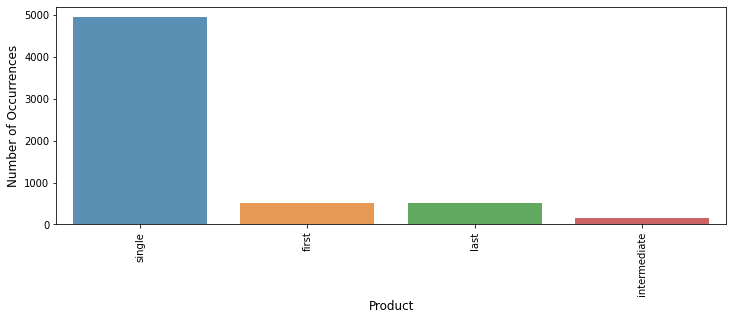

In [11]:
cnt_pro = train['MLclass'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

# Creation of embeddings

## Doc2Vec

In [12]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['prep_text']), tags=[r.MLclass]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['prep_text']), tags=[r.MLclass]), axis=1)

import multiprocessing

from gensim.models import Doc2Vec

from tqdm import tqdm
cores = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 6128/6128 [00:00<00:00, 6470970.52it/s]


In [13]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=20)) for doc in sents])
    return targets, regressors

In [14]:
y_train, X_train_d2v = vec_for_learning(model_dbow, train_tagged)
y_test, X_test_d2v = vec_for_learning(model_dbow, test_tagged)



## TF-IDF

In [15]:

data=train.copy()
data=data.append(test)

corpus = data['prep_text']
vectorizer = TfidfVectorizer()
tf_idf_vectorizer = vectorizer.fit(corpus)

X_train_tf_idf=np.asarray(tf_idf_vectorizer.transform(train.prep_text).todense())
X_test_tf_idf=(tf_idf_vectorizer.transform(test.prep_text).todense())


pca=PCA(n_components=1000, random_state=13)
pca_tr=pca.fit(X_train_tf_idf)


cum_var=pca.explained_variance_ratio_.cumsum()

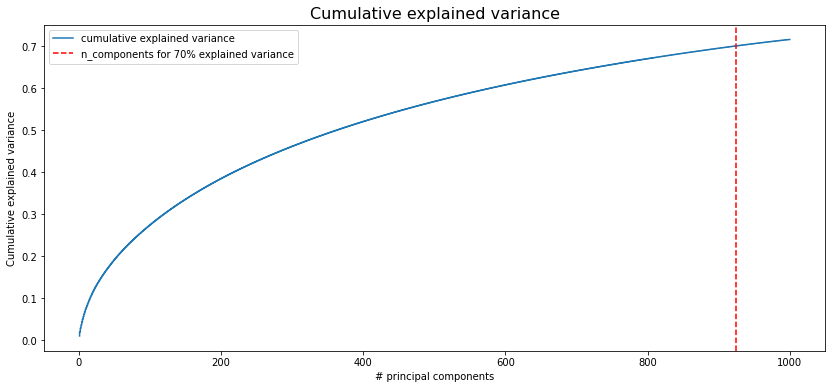

In [16]:
plt.figure(figsize=(14, 6))
plt.step(np.arange(1,1001),cum_var,label='cumulative explained variance')
plt.axvline(np.where(cum_var>0.7)[0][0], color='r', linestyle='--',label='n_components for 70% explained variance')


plt.legend()
plt.title('Cumulative explained variance',fontsize=16)
plt.xlabel('# principal components')
plt.ylabel('Cumulative explained variance')
plt.show()



In [17]:
pca=PCA(n_components=np.where(cum_var>0.7)[0][0], random_state=13)
pca_tr=pca.fit(X_train_tf_idf)
X_train_tf_idf=pca_tr.transform(X_train_tf_idf)
X_test_tf_idf=pca_tr.transform(X_test_tf_idf)

In [18]:

print(f'distribution of train target: {np.array(list(Counter(y_train).values()))/len(y_train)}')
print(f'distribution of test target: {np.array(list(Counter(y_test).values()))/len(y_test)}')


distribution of train target: [0.80662533 0.08289817 0.08420366 0.02627285]
distribution of test target: [0.79177546 0.08942559 0.09464752 0.02415144]


### BERT Sentencce embeddings

In [ ]:
embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
corpus_embeddings=[]
for text in data['prep_text']:
    corpus_embeddings.append(embedder.encode(text))
bert_matrix=np.stack( corpus_embeddings, axis=0 )
bert_train=bert_matrix[:train.shape[0],:]
bert_test=bert_matrix[train.shape[0]:,:]




In [19]:
#Просто выкачивает дату сразу , которую я один раз уже прогнал
bert_matrix=np.array(pd.read_csv('bert_embedding.csv'))
bert_train=bert_matrix[:train.shape[0],:]
bert_test=bert_matrix[train.shape[0]:,:]



# Model estimation

## Baseline Logistic regression


In [75]:
embeddings={'train':{'tf-idf':X_train_tf_idf,'doc2vec':X_train_d2v,'bert':bert_train},
            'test':{'tf-idf':X_test_tf_idf,'doc2vec':X_test_d2v,'bert':bert_test}}
from sklearn.metrics import accuracy_score, f1_score,classification_report 
from sklearn.linear_model import LogisticRegression
logit=LogisticRegression(penalty='none',max_iter=10000)
for key in embeddings['train'].keys():
    logit.fit(embeddings['train'][key], y_train)
    y_pred=logit.predict(embeddings['test'][key])
    print(f'precision_score for {key} embedding matrix is ' + str(precision_score(y_pred,y_test,average='macro')))
    
    

precision_score for tf-idf embedding matrix is 0.7369269958530547


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


precision_score for doc2vec embedding matrix is 0.3183238438636842
precision_score for bert embedding matrix is 0.6306114413486641


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Stacking

In [20]:
embeddings={'train':{'tf-idf':X_train_tf_idf,'doc2vec':X_train_d2v,'bert':bert_train},
            'test':{'tf-idf':X_test_tf_idf,'doc2vec':X_test_d2v,'bert':bert_test}}


base1 = ('rf', RandomForestClassifier(n_estimators = 100))
base2 = ('et', ExtraTreesClassifier(n_estimators=100))
# base3 = ('ridge1', Ridge(alpha=10))
# base4 = ('ridge2', Ridge(alpha=1))
# base5 = ('ridge3', Ridge(alpha=0.1))
base6 = ('dt', DecisionTreeClassifier())
base7 = ('dt_small', DecisionTreeClassifier(max_depth = 15, min_samples_leaf=5))
base8 = ('knn1', KNeighborsClassifier(n_neighbors=10))
base9 = ('knn2', KNeighborsClassifier(n_neighbors=5))
base10 = ('knn3', KNeighborsClassifier(n_neighbors=1))
# base4 = ('lr', OneVsOneClassifier(LogisticRegression()))
meta = RandomForestClassifier()

stacking = StackingClassifier([base1, base2, base6, base7, base8, base9, base10], meta, cv=10)
for key in embeddings['train'].keys():
    stacking.fit(embeddings['train'][key], y_train)
    y_pred=stacking.predict(embeddings['test'][key])
    print(f'Testing results on {key} embedder \n { classification_report(y_test, y_pred)}')

# clf = Pipeline([('stacking', stacking), ('clf', OneVsRestClassifier(RandomForestClassifier(n_estimators=100)))])


Testing results on tf-idf embedder 
               precision    recall  f1-score   support

       first       0.76      0.71      0.73       137
intermediate       0.80      0.65      0.72        37
        last       0.88      0.59      0.70       145
      single       0.93      0.98      0.96      1213

    accuracy                           0.91      1532
   macro avg       0.84      0.73      0.78      1532
weighted avg       0.91      0.91      0.91      1532

Testing results on doc2vec embedder 
               precision    recall  f1-score   support

       first       0.00      0.00      0.00       137
intermediate       0.40      0.05      0.10        37
        last       0.14      0.01      0.03       145
      single       0.79      0.99      0.88      1213

    accuracy                           0.78      1532
   macro avg       0.33      0.26      0.25      1532
weighted avg       0.65      0.78      0.70      1532

Testing results on bert embedder 
               precis

## Random Forest

In [47]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score,classification_report 


embeddings={'train':{'tf-idf':X_train_tf_idf,'doc2vec':X_train_d2v,'bert':bert_train},
            'test':{'tf-idf':X_test_tf_idf,'doc2vec':X_test_d2v,'bert':bert_test}}


clf=RandomForestClassifier(n_estimators=100,random_state=42)

for key in embeddings['train'].keys():
    clf.fit(embeddings['train'][key], y_train)
    y_pred=clf.predict(embeddings['test'][key])
    print(f'Testing results on {key} embedder \n { classification_report(y_test, y_pred)}')
    #print(f'Testing F1 score on {key} embedder is {accuracy_score(y_test, y_pred) }')
    #print(f'Testing F1 score on {key} embedder is {f1_score(y_test, y_pred,average='weighted') }')




Testing results on tf-idf embedder 
               precision    recall  f1-score   support

       first       0.91      0.54      0.68       137
intermediate       0.85      0.59      0.70        37
        last       0.96      0.48      0.64       145
      single       0.89      0.99      0.94      1213

    accuracy                           0.89      1532
   macro avg       0.90      0.65      0.74      1532
weighted avg       0.90      0.89      0.88      1532

Testing results on doc2vec embedder 
               precision    recall  f1-score   support

       first       0.88      0.05      0.10       137
intermediate       0.17      0.03      0.05        37
        last       0.19      0.02      0.04       145
      single       0.80      0.99      0.88      1213

    accuracy                           0.79      1532
   macro avg       0.51      0.27      0.27      1532
weighted avg       0.73      0.79      0.71      1532

Testing results on bert embedder 
               precis

### Parameter tuning

In [42]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = np.arange(200,2001,200)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = list(np.arange(4,41,2))+['None']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [26]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
best_params=[]
for key in embeddings['train'].keys():
    rf_random.fit(embeddings['train'][key], y_train)
    
    y_pred=rf_random.predict(embeddings['test'][key])
    best_params.append([key,rf_random.best_params_])
    print(f'Testing results on {key} embedder with best parameters: {rf_random.best_params_} \n { classification_report(y_test, y_pred)}')
# Fit the random search model


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/opt/homebrew/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/homebrew/lib/python3.9/site-packages/joblib

Testing results on tf-idf embedder with best parameters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 38} 
               precision    recall  f1-score   support

       first       0.92      0.50      0.65       137
intermediate       0.85      0.59      0.70        37
        last       0.97      0.47      0.63       145
      single       0.89      1.00      0.94      1213

    accuracy                           0.89      1532
   macro avg       0.91      0.64      0.73      1532
weighted avg       0.90      0.89      0.88      1532

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/opt/homebrew/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/homebrew/lib/python3.9/site-packages/joblib

Testing results on doc2vec embedder with best parameters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 38} 
               precision    recall  f1-score   support

       first       0.89      0.29      0.44       137
intermediate       1.00      0.27      0.43        37
        last       0.97      0.26      0.40       145
      single       0.84      1.00      0.91      1213

    accuracy                           0.85      1532
   macro avg       0.93      0.45      0.55      1532
weighted avg       0.86      0.85      0.81      1532

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/opt/homebrew/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/homebrew/lib/python3.9/site-packages/joblib

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time=   0.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   0.3s
[CV] END max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=  21.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   0.3s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time= 2.8min
[CV] END max_depth=28

In [31]:
#tf-idf
best_params_tf_idf_rf={'n_estimators': 800,
   'min_samples_split': 2,
   'min_samples_leaf': 1,
   'max_features': 'sqrt',
   'max_depth': 38} 
rf_best_tf_idf = RandomForestClassifier(**best_params_tf_idf_rf,n_jobs=-1,random_state=42)
rf_best_tf_idf.fit(embeddings['train']['tf-idf'],y_train)
pred_tf_idf=rf_best_tf_idf.predict(embeddings['test']['tf-idf'])
print(classification_report(pred_tf_idf,y_test))


              precision    recall  f1-score   support

       first       0.52      0.92      0.66        77
intermediate       0.59      0.85      0.70        26
        last       0.47      0.99      0.64        69
      single       1.00      0.89      0.94      1360

    accuracy                           0.89      1532
   macro avg       0.64      0.91      0.73      1532
weighted avg       0.94      0.89      0.91      1532



In [36]:
#doc2vec
best_params_doc2vec_rf={'n_estimators': 800,
   'min_samples_split': 2,
   'min_samples_leaf': 1,
   'max_features': 'sqrt',
   'max_depth': 38}
rf_best_doc2vec = RandomForestClassifier(**best_params_doc2vec_rf,n_jobs=-1,random_state=42)
rf_best_doc2vec.fit(embeddings['train']['doc2vec'],y_train)
pred_doc2vec_rf=rf_best_doc2vec.predict(embeddings['test']['doc2vec'])
print(classification_report(pred_doc2vec_rf,y_test))


              precision    recall  f1-score   support

       first       0.01      0.50      0.03         4
intermediate       0.08      0.60      0.14         5
        last       0.01      0.22      0.03         9
      single       0.99      0.80      0.88      1514

    accuracy                           0.79      1532
   macro avg       0.28      0.53      0.27      1532
weighted avg       0.98      0.79      0.87      1532



In [33]:
# bert
best_params_bert_rf={'n_estimators': 1600,
   'min_samples_split': 2,
   'min_samples_leaf': 1,
   'max_features': 'auto',
   'max_depth': 36}
rf_best_bert = RandomForestClassifier(**best_params_bert_rf,n_jobs=-1,random_state=42)
rf_best_bert.fit(embeddings['train']['doc2vec'],y_train)
pred_bert_rf=rf_best_bert.predict(embeddings['test']['doc2vec'])
print(classification_report(pred_bert_rf,y_test))

              precision    recall  f1-score   support

       first       0.01      0.25      0.01         4
intermediate       0.08      0.60      0.14         5
        last       0.01      0.25      0.03         8
      single       0.99      0.79      0.88      1515

    accuracy                           0.79      1532
   macro avg       0.27      0.47      0.27      1532
weighted avg       0.98      0.79      0.87      1532

